# LightGCN & Baseline Trainers


In [40]:
from pathlib import Path
import time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from IPython.display import display, Image, Markdown
from tqdm.autonotebook import tqdm
import run as m


plt.style.use('seaborn-v0_8-whitegrid')
DEVICE_DEFAULT = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Torch version:', torch.__version__)
print('Device detected:', DEVICE_DEFAULT)


Torch version: 2.9.1
Device detected: cpu


## Configuration
Set `RUN_TRAINING = True` to actually train. Start with the quick settings for paper drafts; bump epochs/steps and remove subsetting when you need final numbers.

In [41]:
DATASET = 'amazon'
DATA_DIR = Path('data') / DATASET
PLOT_DIR = Path('plots')
MODELS = ['lightgcn',  'ngcf', 'mf-bpr', 'wmf', 'mult-vae']

EPOCHS = 100
EVAL_EVERY = 1
STEPS_PER_EPOCH = 128
BATCH_SIZE = 256
EMBED_DIM = 64
LAYERS = 3
NEG_SAMPLER = 'uniform'
LEARNABLE_WEIGHTS = False  # only used by lightgcn
MAX_USERS = 500            # set to None for full data
MAX_ITEMS_PER_USER = 20    # set to None for full data
LR = 1e-3
L2 = 1e-4
BETA_VAE = 0.2
WMF_ALPHA = 1.0
VAE_HIDDEN = 600
VAE_DROPOUT = 0.5
FORCE_CPU = False
RUN_TRAINING = True  # flip to True to launch training

PLOT_DIR.mkdir(parents=True, exist_ok=True)


## Helper functions
Builds argparse namespaces, runs each model, aggregates metrics across seeds, and provides simple visualization helpers for saved PNGs.

In [42]:
def build_args(model_name: str):
    argv = [
        '--dataset', DATASET,
        '--epochs', str(EPOCHS),
        '--eval-every', str(EVAL_EVERY),
        '--steps-per-epoch', str(STEPS_PER_EPOCH),
        '--batch-size', str(BATCH_SIZE),
        '--embed-dim', str(EMBED_DIM),
        '--layers', str(LAYERS),
        '--neg-sampler', NEG_SAMPLER,
        '--lr', str(LR),
        '--l2', str(L2),
        '--plot-dir', str(PLOT_DIR),
        '--data-dir', str(DATA_DIR),
        '--model', model_name,
    ]
    if MAX_USERS is not None:
        argv += ['--max-users', str(MAX_USERS)]
    if MAX_ITEMS_PER_USER is not None:
        argv += ['--max-items-per-user', str(MAX_ITEMS_PER_USER)]
    if FORCE_CPU:
        argv += ['--cpu']
    if model_name == 'lightgcn' and LEARNABLE_WEIGHTS:
        argv += ['--learnable-weights']
    if model_name == 'wmf':
        argv += ['--wmf-alpha', str(WMF_ALPHA)]
    if model_name == 'mult-vae':
        argv += ['--vae-hidden', str(VAE_HIDDEN), '--vae-beta', str(BETA_VAE), '--vae-dropout', str(VAE_DROPOUT)]
    return m.parse_args(argv)

RUNNERS = {
    'lightgcn': m.run_lightgcn,
    'ngcf': m.run_ngcf,
    'mf-bpr': m.run_mf,
    'wmf': m.run_wmf,
    'mult-vae': m.run_multvae,
}


def show_saved_plots(model_name: str):
    files = [
        PLOT_DIR / f"{DATASET}_{model_name}_metrics.png",
        PLOT_DIR / f"{DATASET}_{model_name}_epoch_time.png",
        PLOT_DIR / f"{DATASET}_{model_name}_loss.png",
    ]
    for path in files:
        if path.exists():
            display(Markdown(f"**{path.name}**"))
            display(Image(filename=str(path)))


## Run training (toggle with `RUN_TRAINING`)
Quick runs will finish faster thanks to subsetting caps and low epoch counts. For paper-quality numbers, increase epochs/steps and drop the `MAX_*` caps.

In [43]:
runs = []
if RUN_TRAINING:
    for model in MODELS:
        args = build_args(model)
        print(f"=== Training {model} ===")
        metrics = m.run_models(args)
        runs.append({'model': model, 'metrics': metrics})
else:
    print('Training skipped. Set RUN_TRAINING = True above to launch experiments.')


=== Training lightgcn ===
[LightGCN][Seed 42] users=500 items=7895 train_edges=9684 test_users=362


Seed 42:   1%|          | 1/100 [00:00<00:38,  2.57it/s]

Epoch 0: loss=0.6646 | metrics={'recall@20': 0.005320968166272033, 'recall@50': 0.007975971235639746, 'ndcg@20': 0.002246058222471938, 'ndcg@50': 0.003111226659370462} | time=0.34s | throughput=28207.2/s


Seed 42:   2%|▏         | 2/100 [00:00<00:37,  2.64it/s]

Epoch 1: loss=0.6571 | metrics={'recall@20': 0.005320968166272033, 'recall@50': 0.00918837148118916, 'ndcg@20': 0.002215983474564414, 'ndcg@50': 0.003079473440143454} | time=0.31s | throughput=30400.8/s


Seed 42:   3%|▎         | 3/100 [00:01<00:39,  2.45it/s]

Epoch 2: loss=0.6473 | metrics={'recall@20': 0.0035451197053406997, 'recall@50': 0.009556695606419363, 'ndcg@20': 0.0018932633274887723, 'ndcg@50': 0.0033442741759784293} | time=0.38s | throughput=24838.7/s


Seed 42:   4%|▍         | 4/100 [00:01<00:38,  2.49it/s]

Epoch 3: loss=0.6348 | metrics={'recall@20': 0.005939226519337017, 'recall@50': 0.01816089067470283, 'ndcg@20': 0.0032283228547018246, 'ndcg@50': 0.005972264149431424} | time=0.34s | throughput=27915.6/s


Seed 42:   5%|▌         | 5/100 [00:01<00:37,  2.52it/s]

Epoch 4: loss=0.6193 | metrics={'recall@20': 0.009643395278754395, 'recall@50': 0.02069311903566047, 'ndcg@20': 0.005298908420314923, 'ndcg@50': 0.008165842824369385} | time=0.33s | throughput=28455.7/s


Seed 42:   6%|▌         | 6/100 [00:02<00:37,  2.51it/s]

Epoch 5: loss=0.6012 | metrics={'recall@20': 0.011968441319270048, 'recall@50': 0.02345554997488699, 'ndcg@20': 0.007605838628722947, 'ndcg@50': 0.010607326154516667} | time=0.34s | throughput=27469.6/s


Seed 42:   7%|▋         | 7/100 [00:02<00:36,  2.58it/s]

Epoch 6: loss=0.5796 | metrics={'recall@20': 0.014019337016574583, 'recall@50': 0.026563284781516823, 'ndcg@20': 0.009456725176107144, 'ndcg@50': 0.012858546935431026} | time=0.31s | throughput=30204.2/s


Seed 42:   8%|▊         | 8/100 [00:03<00:35,  2.60it/s]

Epoch 7: loss=0.5556 | metrics={'recall@20': 0.01574585635359116, 'recall@50': 0.026079859367152187, 'ndcg@20': 0.010159629774440626, 'ndcg@50': 0.012898402165681708} | time=0.32s | throughput=29364.9/s


Seed 42:   9%|▉         | 9/100 [00:03<00:34,  2.65it/s]

Epoch 8: loss=0.5334 | metrics={'recall@20': 0.015628662313745184, 'recall@50': 0.028780902952173667, 'ndcg@20': 0.010132171667515417, 'ndcg@50': 0.013388738561513652} | time=0.31s | throughput=30516.0/s


Seed 42:  10%|█         | 10/100 [00:03<00:33,  2.66it/s]

Epoch 9: loss=0.5080 | metrics={'recall@20': 0.015613315475193927, 'recall@50': 0.0264788771694849, 'ndcg@20': 0.011017943327884387, 'ndcg@50': 0.0138324309873714} | time=0.32s | throughput=29833.6/s


Seed 42:  11%|█         | 11/100 [00:04<00:32,  2.73it/s]

Epoch 10: loss=0.4842 | metrics={'recall@20': 0.017547017132652488, 'recall@50': 0.02745340141748981, 'ndcg@20': 0.011880023023463668, 'ndcg@50': 0.014693620128756376} | time=0.29s | throughput=32567.4/s


Seed 42:  12%|█▏        | 12/100 [00:04<00:33,  2.63it/s]

Epoch 11: loss=0.4621 | metrics={'recall@20': 0.018928232602265747, 'recall@50': 0.025289497181762377, 'ndcg@20': 0.011985445189470867, 'ndcg@50': 0.013966554517892272} | time=0.36s | throughput=26630.7/s


Seed 42:  13%|█▎        | 13/100 [00:05<00:33,  2.61it/s]

Epoch 12: loss=0.4385 | metrics={'recall@20': 0.02007924549361013, 'recall@50': 0.03357412098404171, 'ndcg@20': 0.012313971577220854, 'ndcg@50': 0.015754624711642417} | time=0.33s | throughput=28360.6/s


Seed 42:  14%|█▍        | 14/100 [00:05<00:32,  2.68it/s]

Epoch 13: loss=0.4193 | metrics={'recall@20': 0.02118421786930074, 'recall@50': 0.034889564288435294, 'ndcg@20': 0.01352525312053458, 'ndcg@50': 0.017013612200270544} | time=0.30s | throughput=31506.0/s


Seed 42:  15%|█▌        | 15/100 [00:05<00:30,  2.79it/s]

Epoch 14: loss=0.4011 | metrics={'recall@20': 0.022010278135668478, 'recall@50': 0.029364702409982256, 'ndcg@20': 0.014179520129049656, 'ndcg@50': 0.01616022963419996} | time=0.27s | throughput=35058.1/s


Seed 42:  16%|█▌        | 16/100 [00:06<00:29,  2.89it/s]

Epoch 15: loss=0.3844 | metrics={'recall@20': 0.01964686499877468, 'recall@50': 0.03178182948180546, 'ndcg@20': 0.012210611172961164, 'ndcg@50': 0.015729679611400683} | time=0.27s | throughput=35704.6/s


Seed 42:  17%|█▋        | 17/100 [00:06<00:28,  2.94it/s]

Epoch 16: loss=0.3717 | metrics={'recall@20': 0.021795422395950857, 'recall@50': 0.031137262262652603, 'ndcg@20': 0.013855015069235012, 'ndcg@50': 0.016591090226021454} | time=0.27s | throughput=35005.0/s


Seed 42:  18%|█▊        | 18/100 [00:06<00:27,  2.96it/s]

Epoch 17: loss=0.3579 | metrics={'recall@20': 0.023176637865564117, 'recall@50': 0.03205807257572812, 'ndcg@20': 0.014550549963169998, 'ndcg@50': 0.017170780937310087} | time=0.28s | throughput=33821.0/s


Seed 42:  19%|█▉        | 19/100 [00:06<00:27,  2.96it/s]

Epoch 18: loss=0.3483 | metrics={'recall@20': 0.025110339523022687, 'recall@50': 0.03159766741919036, 'ndcg@20': 0.015212115286040202, 'ndcg@50': 0.01715322430806037} | time=0.28s | throughput=33385.6/s


Seed 42:  20%|██        | 20/100 [00:07<00:26,  2.97it/s]

Epoch 19: loss=0.3375 | metrics={'recall@20': 0.025478663648252887, 'recall@50': 0.035219521317287346, 'ndcg@20': 0.015952060452080388, 'ndcg@50': 0.018617863352758616} | time=0.28s | throughput=33881.6/s


Seed 42:  21%|██        | 21/100 [00:07<00:26,  2.96it/s]

Epoch 20: loss=0.3297 | metrics={'recall@20': 0.025018258491715135, 'recall@50': 0.03779779019389877, 'ndcg@20': 0.016089074345626064, 'ndcg@50': 0.01965439409832387} | time=0.29s | throughput=33152.3/s


Seed 42:  22%|██▏       | 22/100 [00:08<00:26,  2.96it/s]

Epoch 21: loss=0.3230 | metrics={'recall@20': 0.02522753356286866, 'recall@50': 0.03540368337990245, 'ndcg@20': 0.018212747334987112, 'ndcg@50': 0.02136748267346828} | time=0.28s | throughput=33496.9/s


Seed 42:  23%|██▎       | 23/100 [00:08<00:25,  2.98it/s]

Epoch 22: loss=0.3168 | metrics={'recall@20': 0.025534470333893826, 'recall@50': 0.03733738503736102, 'ndcg@20': 0.01788208271729756, 'ndcg@50': 0.021389464019018} | time=0.28s | throughput=34023.2/s


Seed 42:  24%|██▍       | 24/100 [00:08<00:25,  2.99it/s]

Epoch 23: loss=0.3105 | metrics={'recall@20': 0.025785600419278056, 'recall@50': 0.035465070734107484, 'ndcg@20': 0.017828398123011877, 'ndcg@50': 0.020816758930226782} | time=0.28s | throughput=34109.1/s


Seed 42:  25%|██▌       | 25/100 [00:09<00:25,  3.00it/s]

Epoch 24: loss=0.3062 | metrics={'recall@20': 0.025570744679560442, 'recall@50': 0.03945524875743468, 'ndcg@20': 0.018105954157412004, 'ndcg@50': 0.021956532081051708} | time=0.28s | throughput=34134.5/s


Seed 42:  26%|██▌       | 26/100 [00:09<00:24,  3.02it/s]

Epoch 25: loss=0.3027 | metrics={'recall@20': 0.024128141855742143, 'recall@50': 0.04083646422704794, 'ndcg@20': 0.017855684057914042, 'ndcg@50': 0.02234910451660859} | time=0.27s | throughput=34962.6/s


Seed 42:  27%|██▋       | 27/100 [00:09<00:24,  3.00it/s]

Epoch 26: loss=0.3005 | metrics={'recall@20': 0.023755432919497298, 'recall@50': 0.04083646422704794, 'ndcg@20': 0.01772726708229509, 'ndcg@50': 0.022388754154266007} | time=0.28s | throughput=33465.1/s


Seed 42:  28%|██▊       | 28/100 [00:10<00:24,  3.00it/s]

Epoch 27: loss=0.2962 | metrics={'recall@20': 0.025253842428956532, 'recall@50': 0.038741620764801164, 'ndcg@20': 0.017359783049964283, 'ndcg@50': 0.021313691741142272} | time=0.28s | throughput=33637.6/s


Seed 42:  29%|██▉       | 29/100 [00:10<00:23,  2.98it/s]

Epoch 28: loss=0.2925 | metrics={'recall@20': 0.025691227327667397, 'recall@50': 0.03784883511342795, 'ndcg@20': 0.016991671597000685, 'ndcg@50': 0.020636141166419368} | time=0.29s | throughput=33111.9/s


Seed 42:  30%|███       | 30/100 [00:10<00:23,  2.97it/s]

Epoch 29: loss=0.2921 | metrics={'recall@20': 0.02778397803920264, 'recall@50': 0.038309240269965704, 'ndcg@20': 0.017973366426327398, 'ndcg@50': 0.021262388762149215} | time=0.29s | throughput=33195.9/s


Seed 42:  31%|███       | 31/100 [00:11<00:23,  2.97it/s]

Epoch 30: loss=0.2887 | metrics={'recall@20': 0.025547724421733555, 'recall@50': 0.03812507820735061, 'ndcg@20': 0.0170095568039396, 'ndcg@50': 0.020999090838306568} | time=0.28s | throughput=33323.0/s


Seed 42:  32%|███▏      | 32/100 [00:11<00:22,  2.99it/s]

Epoch 31: loss=0.2875 | metrics={'recall@20': 0.025296594336349325, 'recall@50': 0.037587938858056565, 'ndcg@20': 0.016476486679488575, 'ndcg@50': 0.020418378760051967} | time=0.28s | throughput=34265.2/s


Seed 42:  33%|███▎      | 33/100 [00:11<00:22,  2.96it/s]

Epoch 32: loss=0.2857 | metrics={'recall@20': 0.025756999492887074, 'recall@50': 0.03709417100901607, 'ndcg@20': 0.016724955517100282, 'ndcg@50': 0.02040410574784135} | time=0.29s | throughput=32655.3/s


Seed 42:  34%|███▍      | 34/100 [00:12<00:22,  2.95it/s]

Epoch 33: loss=0.2845 | metrics={'recall@20': 0.025756999492887074, 'recall@50': 0.03824017949648505, 'ndcg@20': 0.016701511460822552, 'ndcg@50': 0.02078086976219209} | time=0.29s | throughput=32775.2/s


Seed 42:  35%|███▌      | 35/100 [00:12<00:21,  2.96it/s]

Epoch 34: loss=0.2835 | metrics={'recall@20': 0.024744108148504015, 'recall@50': 0.040841468630923354, 'ndcg@20': 0.01638697653346204, 'ndcg@50': 0.021409273581736003} | time=0.28s | throughput=33668.5/s


Seed 42:  36%|███▌      | 36/100 [00:12<00:21,  2.96it/s]

Epoch 35: loss=0.2810 | metrics={'recall@20': 0.025599146296359846, 'recall@50': 0.04176728334787427, 'ndcg@20': 0.01783001177314318, 'ndcg@50': 0.022834148580709517} | time=0.29s | throughput=33110.4/s


Seed 42:  37%|███▋      | 37/100 [00:13<00:21,  2.96it/s]

Epoch 36: loss=0.2801 | metrics={'recall@20': 0.02615163248420515, 'recall@50': 0.042480911340507785, 'ndcg@20': 0.017921907990894066, 'ndcg@50': 0.022844490918732942} | time=0.28s | throughput=33280.2/s


Seed 42:  38%|███▊      | 38/100 [00:13<00:20,  2.96it/s]

Epoch 37: loss=0.2791 | metrics={'recall@20': 0.025599146296359846, 'recall@50': 0.04029398684695346, 'ndcg@20': 0.017128098522554137, 'ndcg@50': 0.021793571790201645} | time=0.28s | throughput=33403.9/s


Seed 42:  39%|███▉      | 39/100 [00:13<00:20,  2.98it/s]

Epoch 38: loss=0.2770 | metrics={'recall@20': 0.02663505789856979, 'recall@50': 0.04029398684695346, 'ndcg@20': 0.017888881816584327, 'ndcg@50': 0.022160198395874554} | time=0.28s | throughput=34309.5/s


Seed 42:  40%|████      | 40/100 [00:14<00:20,  2.98it/s]

Epoch 39: loss=0.2775 | metrics={'recall@20': 0.026727138929877343, 'recall@50': 0.04143523356831067, 'ndcg@20': 0.017699824493719717, 'ndcg@50': 0.022424839747319944} | time=0.28s | throughput=33505.5/s


Seed 42:  41%|████      | 41/100 [00:14<00:19,  2.99it/s]

Epoch 40: loss=0.2764 | metrics={'recall@20': 0.026217404649424833, 'recall@50': 0.04277250127298169, 'ndcg@20': 0.01736645710530226, 'ndcg@50': 0.02261394589543096} | time=0.28s | throughput=33963.5/s


Seed 42:  41%|████      | 41/100 [00:14<00:21,  2.79it/s]


Early stopping at epoch 41 | best NDCG@20=0.0182
Saved metrics plot: plots/amazon_lightgcn_metrics.png
Saved epoch time plot: plots/amazon_lightgcn_epoch_time.png
Saved loss plot: plots/amazon_lightgcn_loss.png
[lightgcn] Metrics: {'recall@20': 0.02522753356286866, 'recall@50': 0.03540368337990245, 'ndcg@20': 0.018212747334987112, 'ndcg@50': 0.02136748267346828, 'train_time_s': 14.717548847198486}

== Combined results ==
model    | ndcg@20 | ndcg@50 | recall@20 | recall@50 | train_time_s
---------+---------+---------+-----------+-----------+-------------
lightgcn | 0.0182  | 0.0214  | 0.0252    | 0.0354    | 14.7175     
=== Training ngcf ===
[NGCF][Seed 42] users=500 items=7895 train_edges=9684 test_users=362


Seed 42:   1%|          | 1/100 [00:00<01:12,  1.37it/s]

Epoch 0: loss=0.4795 | metrics={'recall@20': 0.003178337606950576, 'recall@50': 0.004651634107871386, 'ndcg@20': 0.002261947092204936, 'ndcg@50': 0.0026827607635179704} | time=0.67s | throughput=14211.9/s


Seed 42:   2%|▏         | 2/100 [00:01<01:09,  1.41it/s]

Epoch 1: loss=0.2266 | metrics={'recall@20': 0.0033149171270718232, 'recall@50': 0.011295273173726212, 'ndcg@20': 0.0022610627074805814, 'ndcg@50': 0.004038566017657664} | time=0.63s | throughput=14994.4/s


Seed 42:   3%|▎         | 3/100 [00:02<01:07,  1.44it/s]

Epoch 2: loss=0.1809 | metrics={'recall@20': 0.002788739805314391, 'recall@50': 0.005320968166272033, 'ndcg@20': 0.0020018803588426008, 'ndcg@50': 0.0026800715527142355} | time=0.62s | throughput=15292.6/s


Seed 42:   4%|▍         | 4/100 [00:02<01:07,  1.42it/s]

Epoch 3: loss=0.1567 | metrics={'recall@20': 0.0010128913443830571, 'recall@50': 0.0065964715616409104, 'ndcg@20': 0.0004954192083905458, 'ndcg@50': 0.001951090065939242} | time=0.65s | throughput=14504.4/s


Seed 42:   5%|▌         | 5/100 [00:03<01:06,  1.43it/s]

Epoch 4: loss=0.1416 | metrics={'recall@20': 0.0014732965009208103, 'recall@50': 0.00619244935543278, 'ndcg@20': 0.0005119201285439134, 'ndcg@50': 0.0017995176039451281} | time=0.63s | throughput=14941.6/s


Seed 42:   6%|▌         | 6/100 [00:04<01:05,  1.42it/s]

Epoch 5: loss=0.1282 | metrics={'recall@20': 0.004258747697974218, 'recall@50': 0.007019085886489202, 'ndcg@20': 0.0014000366089242206, 'ndcg@50': 0.0022605631785229544} | time=0.64s | throughput=14712.5/s


Seed 42:   7%|▋         | 7/100 [00:05<01:18,  1.18it/s]

Epoch 6: loss=0.1205 | metrics={'recall@20': 0.0028775322283609572, 'recall@50': 0.004908895585691166, 'ndcg@20': 0.002377388073837859, 'ndcg@50': 0.0030433014838566236} | time=1.06s | throughput=8969.8/s


Seed 42:   8%|▊         | 8/100 [00:06<01:19,  1.15it/s]

Epoch 7: loss=0.1130 | metrics={'recall@20': 0.004488950276243094, 'recall@50': 0.0054864947820748924, 'ndcg@20': 0.003054154226323568, 'ndcg@50': 0.003407405547961154} | time=0.85s | throughput=11205.9/s


Seed 42:   9%|▉         | 9/100 [00:07<01:17,  1.18it/s]

Epoch 8: loss=0.1111 | metrics={'recall@20': 0.0028775322283609572, 'recall@50': 0.012480268350434094, 'ndcg@20': 0.001986000514512621, 'ndcg@50': 0.004149500903170573} | time=0.75s | throughput=12653.9/s


Seed 42:  10%|█         | 10/100 [00:07<01:13,  1.22it/s]

Epoch 9: loss=0.1056 | metrics={'recall@20': 0.008057090239410682, 'recall@50': 0.014168420591072525, 'ndcg@20': 0.0036449447851232657, 'ndcg@50': 0.005466102548270812} | time=0.70s | throughput=13536.1/s


Seed 42:  11%|█         | 11/100 [00:08<01:11,  1.25it/s]

Epoch 10: loss=0.1020 | metrics={'recall@20': 0.009284837323511357, 'recall@50': 0.01221608348680172, 'ndcg@20': 0.004378612337673913, 'ndcg@50': 0.005344955970651362} | time=0.69s | throughput=13758.9/s


Seed 42:  12%|█▏        | 12/100 [00:09<01:07,  1.30it/s]

Epoch 11: loss=0.0979 | metrics={'recall@20': 0.007097912829957028, 'recall@50': 0.011855432780847146, 'ndcg@20': 0.0030910042517359095, 'ndcg@50': 0.004320622126511135} | time=0.63s | throughput=15071.3/s


Seed 42:  13%|█▎        | 13/100 [00:09<01:04,  1.35it/s]

Epoch 12: loss=0.0937 | metrics={'recall@20': 0.007826887661141806, 'recall@50': 0.014096071209330877, 'ndcg@20': 0.002323043794726957, 'ndcg@50': 0.0042492609769452525} | time=0.61s | throughput=15447.5/s


Seed 42:  14%|█▍        | 14/100 [00:10<01:01,  1.39it/s]

Epoch 13: loss=0.0947 | metrics={'recall@20': 0.004538279400157853, 'recall@50': 0.009103963869157239, 'ndcg@20': 0.0023139095600234164, 'ndcg@50': 0.0037569490744378694} | time=0.61s | throughput=15410.5/s


Seed 42:  15%|█▌        | 15/100 [00:11<01:00,  1.42it/s]

Epoch 14: loss=0.0924 | metrics={'recall@20': 0.002302025782688766, 'recall@50': 0.010462159080943612, 'ndcg@20': 0.0015756815447719238, 'ndcg@50': 0.0038498258593509796} | time=0.61s | throughput=15407.8/s


Seed 42:  16%|█▌        | 16/100 [00:11<00:58,  1.43it/s]

Epoch 15: loss=0.0915 | metrics={'recall@20': 0.001611418047882136, 'recall@50': 0.009039287906691222, 'ndcg@20': 0.0012468820867955963, 'ndcg@50': 0.0033785313649355646} | time=0.62s | throughput=15323.6/s


Seed 42:  17%|█▋        | 17/100 [00:12<00:57,  1.45it/s]

Epoch 16: loss=0.0915 | metrics={'recall@20': 0.004066912216083487, 'recall@50': 0.009418574059458038, 'ndcg@20': 0.0021235357631251236, 'ndcg@50': 0.003886295251247821} | time=0.61s | throughput=15442.1/s


Seed 42:  18%|█▊        | 18/100 [00:13<00:56,  1.45it/s]

Epoch 17: loss=0.0885 | metrics={'recall@20': 0.0049877225291589935, 'recall@50': 0.010845830044725072, 'ndcg@20': 0.002576302125867891, 'ndcg@50': 0.004363730188382587} | time=0.62s | throughput=15205.3/s


Seed 42:  19%|█▉        | 19/100 [00:14<00:55,  1.46it/s]

Epoch 18: loss=0.0862 | metrics={'recall@20': 0.006829343155310006, 'recall@50': 0.011602209944751382, 'ndcg@20': 0.003689190479945341, 'ndcg@50': 0.004922237049748277} | time=0.62s | throughput=15382.1/s


Seed 42:  20%|██        | 20/100 [00:14<00:54,  1.46it/s]

Epoch 19: loss=0.0860 | metrics={'recall@20': 0.004680785758133825, 'recall@50': 0.01210098219766728, 'ndcg@20': 0.002392896357822901, 'ndcg@50': 0.004636993620961721} | time=0.62s | throughput=15274.5/s


Seed 42:  21%|██        | 21/100 [00:15<00:54,  1.45it/s]

Epoch 20: loss=0.0839 | metrics={'recall@20': 0.0032995702885205646, 'recall@50': 0.008709330877839165, 'ndcg@20': 0.001864070673653604, 'ndcg@50': 0.0035426613269900925} | time=0.64s | throughput=14811.4/s


Seed 42:  22%|██▏       | 22/100 [00:16<00:53,  1.46it/s]

Epoch 21: loss=0.0837 | metrics={'recall@20': 0.003759975445058318, 'recall@50': 0.008686310620012277, 'ndcg@20': 0.001992295066267415, 'ndcg@50': 0.0034222520337735987} | time=0.62s | throughput=15381.3/s


Seed 42:  23%|██▎       | 23/100 [00:16<00:52,  1.46it/s]

Epoch 22: loss=0.0832 | metrics={'recall@20': 0.004312461632903621, 'recall@50': 0.01821669736034377, 'ndcg@20': 0.0024741279189212317, 'ndcg@50': 0.005890122156476462} | time=0.62s | throughput=15346.8/s


Seed 42:  24%|██▍       | 24/100 [00:17<00:51,  1.47it/s]

Epoch 23: loss=0.0815 | metrics={'recall@20': 0.0033916513198281157, 'recall@50': 0.020591072524774184, 'ndcg@20': 0.0024753628675122912, 'ndcg@50': 0.006955930712399568} | time=0.61s | throughput=15459.1/s


Seed 42:  25%|██▌       | 25/100 [00:18<00:50,  1.47it/s]

Epoch 24: loss=0.0803 | metrics={'recall@20': 0.006614487415592387, 'recall@50': 0.02355739717618171, 'ndcg@20': 0.0041512168705587675, 'ndcg@50': 0.008555163238781794} | time=0.62s | throughput=15400.9/s


Seed 42:  26%|██▌       | 26/100 [00:18<00:50,  1.47it/s]

Epoch 25: loss=0.0809 | metrics={'recall@20': 0.012737875997544505, 'recall@50': 0.017989783390335874, 'ndcg@20': 0.004612969259986333, 'ndcg@50': 0.006320651560117044} | time=0.62s | throughput=15305.2/s


Seed 42:  27%|██▋       | 27/100 [00:19<00:49,  1.47it/s]

Epoch 26: loss=0.0807 | metrics={'recall@20': 0.010550951503990177, 'recall@50': 0.01836311191944149, 'ndcg@20': 0.004464846869813582, 'ndcg@50': 0.00702552286116988} | time=0.61s | throughput=15418.9/s


Seed 42:  28%|██▊       | 28/100 [00:20<00:48,  1.47it/s]

Epoch 27: loss=0.0798 | metrics={'recall@20': 0.008709330877839165, 'recall@50': 0.01740393450998784, 'ndcg@20': 0.0039648396782583795, 'ndcg@50': 0.006439344005693043} | time=0.62s | throughput=15209.8/s


Seed 42:  29%|██▉       | 29/100 [00:20<00:49,  1.44it/s]

Epoch 28: loss=0.0786 | metrics={'recall@20': 0.005946899938612645, 'recall@50': 0.018619003770937476, 'ndcg@20': 0.0028562367190243746, 'ndcg@50': 0.0065662378478152} | time=0.67s | throughput=14133.4/s


Seed 42:  30%|███       | 30/100 [00:21<00:49,  1.40it/s]

Epoch 29: loss=0.0799 | metrics={'recall@20': 0.010577260370078048, 'recall@50': 0.019954178724896958, 'ndcg@20': 0.004740711702013508, 'ndcg@50': 0.007363125218830622} | time=0.69s | throughput=13682.1/s


Seed 42:  31%|███       | 31/100 [00:22<00:48,  1.44it/s]

Epoch 30: loss=0.0762 | metrics={'recall@20': 0.012254450583179867, 'recall@50': 0.020972074473155425, 'ndcg@20': 0.005250134213125157, 'ndcg@50': 0.007678299104960489} | time=0.60s | throughput=15873.4/s


Seed 42:  32%|███▏      | 32/100 [00:22<00:46,  1.45it/s]

Epoch 31: loss=0.0795 | metrics={'recall@20': 0.012303779707094625, 'recall@50': 0.017063635046459934, 'ndcg@20': 0.005392881449219277, 'ndcg@50': 0.006932860489638796} | time=0.61s | throughput=15512.9/s


Seed 42:  33%|███▎      | 33/100 [00:23<00:45,  1.46it/s]

Epoch 32: loss=0.0766 | metrics={'recall@20': 0.0054634745242480055, 'recall@50': 0.01729383762472881, 'ndcg@20': 0.002942742961256261, 'ndcg@50': 0.006040122486959681} | time=0.61s | throughput=15470.7/s


Seed 42:  34%|███▍      | 34/100 [00:24<00:45,  1.46it/s]

Epoch 33: loss=0.0778 | metrics={'recall@20': 0.0063842848373235105, 'recall@50': 0.018232663791755793, 'ndcg@20': 0.0034516611433853834, 'ndcg@50': 0.006537807023850653} | time=0.62s | throughput=15287.7/s


Seed 42:  35%|███▌      | 35/100 [00:24<00:44,  1.47it/s]

Epoch 34: loss=0.0759 | metrics={'recall@20': 0.007200955888801193, 'recall@50': 0.020470633204839304, 'ndcg@20': 0.004110776524431812, 'ndcg@50': 0.007972500741237556} | time=0.61s | throughput=15427.4/s


Seed 42:  36%|███▌      | 36/100 [00:25<00:43,  1.47it/s]

Epoch 35: loss=0.0764 | metrics={'recall@20': 0.006026922739629923, 'recall@50': 0.01934530958672203, 'ndcg@20': 0.00445677600670681, 'ndcg@50': 0.00810226029715648} | time=0.61s | throughput=15437.0/s


Seed 42:  37%|███▋      | 37/100 [00:26<00:42,  1.47it/s]

Epoch 36: loss=0.0763 | metrics={'recall@20': 0.007062834341839868, 'recall@50': 0.023373854706427367, 'ndcg@20': 0.004546194521006004, 'ndcg@50': 0.008601253845731807} | time=0.62s | throughput=15247.7/s


Seed 42:  38%|███▊      | 38/100 [00:27<00:42,  1.47it/s]

Epoch 37: loss=0.0746 | metrics={'recall@20': 0.011065070595457336, 'recall@50': 0.018002461213486916, 'ndcg@20': 0.005580012429601592, 'ndcg@50': 0.007864666009600991} | time=0.62s | throughput=15209.1/s


Seed 42:  39%|███▉      | 39/100 [00:27<00:41,  1.47it/s]

Epoch 38: loss=0.0753 | metrics={'recall@20': 0.007310099554274428, 'recall@50': 0.021455499887520064, 'ndcg@20': 0.003964360157641788, 'ndcg@50': 0.007863963368465891} | time=0.62s | throughput=15253.9/s


Seed 42:  40%|████      | 40/100 [00:28<00:40,  1.47it/s]

Epoch 39: loss=0.0741 | metrics={'recall@20': 0.006834347559185415, 'recall@50': 0.014779625117722642, 'ndcg@20': 0.0032914869997262347, 'ndcg@50': 0.005624699516283413} | time=0.62s | throughput=15384.5/s


Seed 42:  41%|████      | 41/100 [00:29<00:40,  1.47it/s]

Epoch 40: loss=0.0737 | metrics={'recall@20': 0.008346011156484373, 'recall@50': 0.022813695099306436, 'ndcg@20': 0.003603926938217378, 'ndcg@50': 0.007299424735060952} | time=0.61s | throughput=15439.4/s


Seed 42:  42%|████▏     | 42/100 [00:29<00:39,  1.47it/s]

Epoch 41: loss=0.0735 | metrics={'recall@20': 0.008307644060106227, 'recall@50': 0.019728980550503487, 'ndcg@20': 0.00404137361672665, 'ndcg@50': 0.007269611419892472} | time=0.62s | throughput=15313.5/s


Seed 42:  43%|████▎     | 43/100 [00:30<00:38,  1.47it/s]

Epoch 42: loss=0.0737 | metrics={'recall@20': 0.008341006752608961, 'recall@50': 0.02030448699617568, 'ndcg@20': 0.0042636182093014315, 'ndcg@50': 0.0076317956213678775} | time=0.62s | throughput=15308.4/s


Seed 42:  44%|████▍     | 44/100 [00:31<00:38,  1.45it/s]

Epoch 43: loss=0.0747 | metrics={'recall@20': 0.010873235113566604, 'recall@50': 0.024125849795439032, 'ndcg@20': 0.007511882370982423, 'ndcg@50': 0.011381215109229138} | time=0.65s | throughput=14498.9/s


Seed 42:  45%|████▌     | 45/100 [00:31<00:37,  1.46it/s]

Epoch 44: loss=0.0730 | metrics={'recall@20': 0.011487108655616942, 'recall@50': 0.026723850321616355, 'ndcg@20': 0.006913770542792597, 'ndcg@50': 0.011045603227700986} | time=0.62s | throughput=15379.4/s


Seed 42:  46%|████▌     | 46/100 [00:32<00:36,  1.46it/s]

Epoch 45: loss=0.0740 | metrics={'recall@20': 0.020027624309392263, 'recall@50': 0.03169889502762431, 'ndcg@20': 0.00961029403425704, 'ndcg@50': 0.01325216280507893} | time=0.62s | throughput=15329.3/s


Seed 42:  47%|████▋     | 47/100 [00:33<00:36,  1.47it/s]

Epoch 46: loss=0.0739 | metrics={'recall@20': 0.016766421117249845, 'recall@50': 0.0315717355081996, 'ndcg@20': 0.010302385954565191, 'ndcg@50': 0.014518552274890904} | time=0.62s | throughput=15401.4/s


Seed 42:  48%|████▊     | 48/100 [00:33<00:35,  1.47it/s]

Epoch 47: loss=0.0749 | metrics={'recall@20': 0.019160527931246164, 'recall@50': 0.0287899190886978, 'ndcg@20': 0.010943305533458335, 'ndcg@50': 0.013803144452454438} | time=0.62s | throughput=15284.4/s


Seed 42:  49%|████▉     | 49/100 [00:34<00:34,  1.47it/s]

Epoch 48: loss=0.0733 | metrics={'recall@20': 0.0189073050951504, 'recall@50': 0.026549280660214072, 'ndcg@20': 0.011980786112693237, 'ndcg@50': 0.014348214709140949} | time=0.61s | throughput=15525.5/s


Seed 42:  50%|█████     | 50/100 [00:35<00:33,  1.47it/s]

Epoch 49: loss=0.0718 | metrics={'recall@20': 0.018688064544418133, 'recall@50': 0.027331969426328245, 'ndcg@20': 0.01182502495507882, 'ndcg@50': 0.014211704591717963} | time=0.62s | throughput=15294.2/s


Seed 42:  51%|█████     | 51/100 [00:35<00:33,  1.48it/s]

Epoch 50: loss=0.0738 | metrics={'recall@20': 0.016063755152152942, 'recall@50': 0.025720551378446112, 'ndcg@20': 0.009846135798262195, 'ndcg@50': 0.01273942428638333} | time=0.61s | throughput=15440.0/s


Seed 42:  52%|█████▏    | 52/100 [00:36<00:32,  1.48it/s]

Epoch 51: loss=0.0733 | metrics={'recall@20': 0.01569543102692274, 'recall@50': 0.025187450670876087, 'ndcg@20': 0.009357442500194858, 'ndcg@50': 0.011834428269816104} | time=0.61s | throughput=15457.2/s


Seed 42:  53%|█████▎    | 53/100 [00:37<00:31,  1.48it/s]

Epoch 52: loss=0.0728 | metrics={'recall@20': 0.014720906778917827, 'recall@50': 0.028146721495868745, 'ndcg@20': 0.009542742681134454, 'ndcg@50': 0.013229328484070014} | time=0.61s | throughput=15498.6/s


Seed 42:  54%|█████▍    | 54/100 [00:37<00:31,  1.48it/s]

Epoch 53: loss=0.0717 | metrics={'recall@20': 0.011099052880820835, 'recall@50': 0.025215475332578383, 'ndcg@20': 0.0075850632293670076, 'ndcg@50': 0.011629254584843438} | time=0.62s | throughput=15262.1/s


Seed 42:  55%|█████▌    | 55/100 [00:38<00:30,  1.47it/s]

Epoch 54: loss=0.0723 | metrics={'recall@20': 0.010704419889502763, 'recall@50': 0.022161454460877947, 'ndcg@20': 0.0073671440149458345, 'ndcg@50': 0.010798206981642206} | time=0.62s | throughput=15292.0/s


Seed 42:  56%|█████▌    | 56/100 [00:39<00:30,  1.45it/s]

Epoch 55: loss=0.0740 | metrics={'recall@20': 0.01761049723756906, 'recall@50': 0.029177974863493907, 'ndcg@20': 0.010238383478651279, 'ndcg@50': 0.013422315583879138} | time=0.66s | throughput=14447.4/s


Seed 42:  57%|█████▋    | 57/100 [00:40<00:29,  1.43it/s]

Epoch 56: loss=0.0728 | metrics={'recall@20': 0.013651012891344383, 'recall@50': 0.031166010048742643, 'ndcg@20': 0.008424856004817597, 'ndcg@50': 0.013315237481748822} | time=0.65s | throughput=14465.9/s


Seed 42:  58%|█████▊    | 58/100 [00:40<00:28,  1.46it/s]

Epoch 57: loss=0.0721 | metrics={'recall@20': 0.013213627992633517, 'recall@50': 0.03180694249034388, 'ndcg@20': 0.0065731869898149435, 'ndcg@50': 0.011792550571702167} | time=0.60s | throughput=15837.5/s


Seed 42:  59%|█████▉    | 59/100 [00:41<00:28,  1.46it/s]

Epoch 58: loss=0.0733 | metrics={'recall@20': 0.01803753970160408, 'recall@50': 0.029692713547821832, 'ndcg@20': 0.009979429683264596, 'ndcg@50': 0.013391720335174126} | time=0.62s | throughput=15363.5/s


Seed 42:  60%|██████    | 60/100 [00:42<00:27,  1.46it/s]

Epoch 59: loss=0.0716 | metrics={'recall@20': 0.01515500306936771, 'recall@50': 0.029063493167220237, 'ndcg@20': 0.00899064011032367, 'ndcg@50': 0.013028896204339457} | time=0.63s | throughput=15108.3/s


Seed 42:  61%|██████    | 61/100 [00:42<00:26,  1.46it/s]

Epoch 60: loss=0.0704 | metrics={'recall@20': 0.013109488731035691, 'recall@50': 0.027576219454071967, 'ndcg@20': 0.007012511518200686, 'ndcg@50': 0.010794931552300746} | time=0.62s | throughput=15325.4/s


Seed 42:  62%|██████▏   | 62/100 [00:43<00:25,  1.46it/s]

Epoch 61: loss=0.0710 | metrics={'recall@20': 0.01596400070156976, 'recall@50': 0.029597963501114065, 'ndcg@20': 0.007997571669385204, 'ndcg@50': 0.011649473371604914} | time=0.62s | throughput=15246.6/s


Seed 42:  63%|██████▎   | 63/100 [00:44<00:25,  1.47it/s]

Epoch 62: loss=0.0704 | metrics={'recall@20': 0.01126786810488468, 'recall@50': 0.02354000091509099, 'ndcg@20': 0.005880813428967876, 'ndcg@50': 0.009300876895447592} | time=0.61s | throughput=15460.3/s


Seed 42:  64%|██████▍   | 64/100 [00:44<00:24,  1.47it/s]

Epoch 63: loss=0.0708 | metrics={'recall@20': 0.007305714743259782, 'recall@50': 0.026072229276048638, 'ndcg@20': 0.004453862389951249, 'ndcg@50': 0.009551347673113405} | time=0.62s | throughput=15315.7/s


Seed 42:  65%|██████▌   | 65/100 [00:45<00:24,  1.46it/s]

Epoch 64: loss=0.0701 | metrics={'recall@20': 0.013114493134911101, 'recall@50': 0.028742579183967602, 'ndcg@20': 0.006898185939194673, 'ndcg@50': 0.01120317012567933} | time=0.64s | throughput=14879.9/s


Seed 42:  66%|██████▌   | 66/100 [00:46<00:23,  1.45it/s]

Epoch 65: loss=0.0722 | metrics={'recall@20': 0.013915197754976762, 'recall@50': 0.028561086136752723, 'ndcg@20': 0.007643505423829682, 'ndcg@50': 0.011456084899252095} | time=0.63s | throughput=14957.2/s


Seed 42:  67%|██████▋   | 67/100 [00:46<00:22,  1.46it/s]

Epoch 66: loss=0.0712 | metrics={'recall@20': 0.010213940648723257, 'recall@50': 0.023517556921952787, 'ndcg@20': 0.008092226963470277, 'ndcg@50': 0.011754272121404553} | time=0.62s | throughput=15265.8/s


Seed 42:  68%|██████▊   | 68/100 [00:47<00:21,  1.46it/s]

Epoch 67: loss=0.0713 | metrics={'recall@20': 0.006914370360202691, 'recall@50': 0.0255120696689277, 'ndcg@20': 0.007060620152832576, 'ndcg@50': 0.011917914010380748} | time=0.62s | throughput=15216.9/s


Seed 42:  68%|██████▊   | 68/100 [00:48<00:22,  1.41it/s]


Early stopping at epoch 68 | best NDCG@20=0.0120
Saved metrics plot: plots/amazon_ngcf_metrics.png
Saved epoch time plot: plots/amazon_ngcf_epoch_time.png
Saved loss plot: plots/amazon_ngcf_loss.png
[ngcf] Metrics: {'recall@20': 0.0189073050951504, 'recall@50': 0.026549280660214072, 'ndcg@20': 0.011980786112693237, 'ndcg@50': 0.014348214709140949, 'train_time_s': 48.20709729194641}

== Combined results ==
model | ndcg@20 | ndcg@50 | recall@20 | recall@50 | train_time_s
------+---------+---------+-----------+-----------+-------------
ngcf  | 0.0120  | 0.0143  | 0.0189    | 0.0265    | 48.2071     
=== Training mf-bpr ===
[MF-BPR][Seed 42] users=500 items=7895 train_edges=9684 test_users=362


Seed 42:   1%|          | 1/100 [00:00<00:13,  7.57it/s]

Epoch 0: loss=0.6909 | metrics={'recall@20': 0.002302025782688766, 'recall@50': 0.005095150399017803, 'ndcg@20': 0.0020626294919750213, 'ndcg@50': 0.002885399504319214} | time=0.08s | throughput=116493.8/s


Seed 42:   2%|▏         | 2/100 [00:00<00:13,  7.50it/s]

Epoch 1: loss=0.6809 | metrics={'recall@20': 0.0028545119705340695, 'recall@50': 0.005796720161361045, 'ndcg@20': 0.002072769522874919, 'ndcg@50': 0.002933004505288101} | time=0.08s | throughput=113350.2/s


Seed 42:   3%|▎         | 3/100 [00:00<00:12,  7.56it/s]

Epoch 2: loss=0.6710 | metrics={'recall@20': 0.00216390423572744, 'recall@50': 0.005796720161361045, 'ndcg@20': 0.0017599106887183581, 'ndcg@50': 0.002893884444281431} | time=0.08s | throughput=117594.8/s


Seed 42:   4%|▍         | 4/100 [00:00<00:12,  7.59it/s]

Epoch 3: loss=0.6628 | metrics={'recall@20': 0.00216390423572744, 'recall@50': 0.0061913531526791195, 'ndcg@20': 0.0017201239560277908, 'ndcg@50': 0.0030053578432319293} | time=0.08s | throughput=117860.9/s


Seed 42:   5%|▌         | 5/100 [00:00<00:12,  7.66it/s]

Epoch 4: loss=0.6553 | metrics={'recall@20': 0.0035451197053407, 'recall@50': 0.005869415712393323, 'ndcg@20': 0.0015716209344299494, 'ndcg@50': 0.0024120361264024625} | time=0.08s | throughput=121465.5/s


Seed 42:   6%|▌         | 6/100 [00:00<00:12,  7.68it/s]

Epoch 5: loss=0.6477 | metrics={'recall@20': 0.004012448247691051, 'recall@50': 0.006698144994161279, 'ndcg@20': 0.0018668106836755918, 'ndcg@50': 0.0027320814441778845} | time=0.08s | throughput=119866.9/s


Seed 42:   7%|▋         | 7/100 [00:00<00:11,  7.76it/s]

Epoch 6: loss=0.6397 | metrics={'recall@20': 0.003249144961852144, 'recall@50': 0.007092777985479352, 'ndcg@20': 0.0014394804822222085, 'ndcg@50': 0.0028272343572444377} | time=0.08s | throughput=125117.1/s


Seed 42:   8%|▊         | 8/100 [00:01<00:11,  7.78it/s]

Epoch 7: loss=0.6323 | metrics={'recall@20': 0.004553626238709111, 'recall@50': 0.007184859016786903, 'ndcg@20': 0.0020450215494014577, 'ndcg@50': 0.0029270098360429132} | time=0.08s | throughput=122473.9/s


Seed 42:   9%|▉         | 9/100 [00:01<00:11,  7.86it/s]

Epoch 8: loss=0.6257 | metrics={'recall@20': 0.004158993247391037, 'recall@50': 0.006494251281980273, 'ndcg@20': 0.0018566394558222302, 'ndcg@50': 0.0026901861453345354} | time=0.07s | throughput=128491.6/s


Seed 42:  10%|█         | 10/100 [00:01<00:11,  7.93it/s]

Epoch 9: loss=0.6180 | metrics={'recall@20': 0.004001140050863807, 'recall@50': 0.006717530474436553, 'ndcg@20': 0.0016247965063189076, 'ndcg@50': 0.002493589330951007} | time=0.07s | throughput=129716.2/s


Seed 42:  11%|█         | 11/100 [00:01<00:11,  7.96it/s]

Epoch 10: loss=0.6099 | metrics={'recall@20': 0.003606507059545733, 'recall@50': 0.005152152942208191, 'ndcg@20': 0.0014742095482393528, 'ndcg@50': 0.00199681557967312} | time=0.07s | throughput=129138.1/s


Seed 42:  12%|█▏        | 12/100 [00:01<00:10,  8.01it/s]

Epoch 11: loss=0.6010 | metrics={'recall@20': 0.003606507059545733, 'recall@50': 0.0069937735683592035, 'ndcg@20': 0.0014469717062507938, 'ndcg@50': 0.002339475417841877} | time=0.07s | throughput=130272.6/s


Seed 42:  13%|█▎        | 13/100 [00:01<00:10,  8.01it/s]

Epoch 12: loss=0.5929 | metrics={'recall@20': 0.002685696746470227, 'recall@50': 0.0049877225291589935, 'ndcg@20': 0.0011462046028790497, 'ndcg@50': 0.0017269308446671264} | time=0.07s | throughput=128136.4/s


Seed 42:  14%|█▍        | 14/100 [00:01<00:10,  8.05it/s]

Epoch 13: loss=0.5840 | metrics={'recall@20': 0.002685696746470227, 'recall@50': 0.0037216083486801715, 'ndcg@20': 0.00104983676302905, 'ndcg@50': 0.0013758343997175339} | time=0.07s | throughput=130143.7/s


Seed 42:  15%|█▌        | 15/100 [00:01<00:10,  8.06it/s]

Epoch 14: loss=0.5743 | metrics={'recall@20': 0.002685696746470227, 'recall@50': 0.004412216083486802, 'ndcg@20': 0.0010018233471870055, 'ndcg@50': 0.0015750771742106514} | time=0.07s | throughput=129545.3/s


Seed 42:  16%|█▌        | 16/100 [00:02<00:10,  8.02it/s]

Epoch 15: loss=0.5640 | metrics={'recall@20': 0.0029158993247391037, 'recall@50': 0.0046633461688710305, 'ndcg@20': 0.0011957797519499002, 'ndcg@50': 0.0017423910498128132} | time=0.08s | throughput=125611.6/s


Seed 42:  17%|█▋        | 17/100 [00:02<00:10,  8.03it/s]

Epoch 16: loss=0.5536 | metrics={'recall@20': 0.0012486745912160275, 'recall@50': 0.0032821306992577713, 'ndcg@20': 0.0007917169602636084, 'ndcg@50': 0.0014872968523156399} | time=0.07s | throughput=129083.6/s


Seed 42:  18%|█▊        | 18/100 [00:02<00:10,  8.04it/s]

Epoch 17: loss=0.5425 | metrics={'recall@20': 0.0004220380601596071, 'recall@50': 0.003815231406827801, 'ndcg@20': 0.0003419696165374471, 'ndcg@50': 0.0014187657802314495} | time=0.07s | throughput=129256.2/s


Seed 42:  19%|█▉        | 19/100 [00:02<00:10,  8.04it/s]

Epoch 18: loss=0.5324 | metrics={'recall@20': 0.0006138735420503376, 'recall@50': 0.004736041719903307, 'ndcg@20': 0.00047749887316732374, 'ndcg@50': 0.0017189444481462348} | time=0.07s | throughput=128811.1/s


Seed 42:  20%|██        | 20/100 [00:02<00:09,  8.01it/s]

Epoch 19: loss=0.5204 | metrics={'recall@20': 0.0007289748311847758, 'recall@50': 0.0046633461688710305, 'ndcg@20': 0.0005809166632798428, 'ndcg@50': 0.0016530717907815046} | time=0.08s | throughput=125810.1/s


Seed 42:  21%|██        | 21/100 [00:02<00:09,  8.00it/s]

Epoch 20: loss=0.5093 | metrics={'recall@20': 0.0004220380601596071, 'recall@50': 0.0073394236050531485, 'ndcg@20': 0.0004644156289554137, 'ndcg@50': 0.0021960924582657545} | time=0.08s | throughput=126235.9/s


Seed 42:  21%|██        | 21/100 [00:02<00:10,  7.55it/s]


Early stopping at epoch 21 | best NDCG@20=0.0021
Saved metrics plot: plots/amazon_mf-bpr_metrics.png
Saved epoch time plot: plots/amazon_mf-bpr_epoch_time.png
Saved loss plot: plots/amazon_mf-bpr_loss.png
[mf-bpr] Metrics: {'recall@20': 0.0028545119705340695, 'recall@50': 0.005796720161361045, 'ndcg@20': 0.002072769522874919, 'ndcg@50': 0.002933004505288101, 'train_time_s': 2.782963991165161}

== Combined results ==
model  | ndcg@20 | ndcg@50 | recall@20 | recall@50 | train_time_s
-------+---------+---------+-----------+-----------+-------------
mf-bpr | 0.0021  | 0.0029  | 0.0029    | 0.0058    | 2.7830      
=== Training wmf ===
[WMF][Seed 42] users=500 items=7895 train_edges=9684 test_users=362


Seed 42:   2%|▏         | 2/100 [00:00<00:06, 14.35it/s]

Epoch 0: loss=0.0112 | metrics={'recall@20': 0.0025322283609576428, 'recall@50': 0.005340699815837937, 'ndcg@20': 0.0019881687492180537, 'ndcg@50': 0.0028449697700480966} | time=0.02s | throughput=497381.2/s
Epoch 1: loss=0.0108 | metrics={'recall@20': 0.0025322283609576428, 'recall@50': 0.005340699815837937, 'ndcg@20': 0.001984539105196982, 'ndcg@50': 0.0028466092050490957} | time=0.02s | throughput=523403.0/s


Seed 42:   2%|▏         | 2/100 [00:00<00:06, 14.35it/s]

Epoch 2: loss=0.0104 | metrics={'recall@20': 0.0032228360957642726, 'recall@50': 0.005340699815837937, 'ndcg@20': 0.002226402078180999, 'ndcg@50': 0.002844082665187989} | time=0.02s | throughput=524707.9/s


Seed 42:   4%|▍         | 4/100 [00:00<00:06, 14.32it/s]

Epoch 3: loss=0.0101 | metrics={'recall@20': 0.0032228360957642726, 'recall@50': 0.005340699815837937, 'ndcg@20': 0.0022224034169866366, 'ndcg@50': 0.0028369255377463706} | time=0.02s | throughput=517231.1/s
Epoch 4: loss=0.0098 | metrics={'recall@20': 0.0025322283609576428, 'recall@50': 0.005340699815837937, 'ndcg@20': 0.0019881687492180537, 'ndcg@50': 0.002836827775773458} | time=0.02s | throughput=517250.8/s


Seed 42:   6%|▌         | 6/100 [00:00<00:06, 14.09it/s]

Epoch 5: loss=0.0095 | metrics={'recall@20': 0.0025322283609576428, 'recall@50': 0.005340699815837937, 'ndcg@20': 0.0021578995446724374, 'ndcg@50': 0.0029960084335220525} | time=0.02s | throughput=424515.5/s


Seed 42:   8%|▊         | 8/100 [00:00<00:06, 13.89it/s]

Epoch 6: loss=0.0092 | metrics={'recall@20': 0.0025322283609576428, 'recall@50': 0.005340699815837937, 'ndcg@20': 0.0021578995446724374, 'ndcg@50': 0.0029801851556583232} | time=0.02s | throughput=433324.2/s
Epoch 7: loss=0.0089 | metrics={'recall@20': 0.0025322283609576428, 'recall@50': 0.005340699815837937, 'ndcg@20': 0.002182902449523277, 'ndcg@50': 0.0029995912700021333} | time=0.02s | throughput=450886.3/s


Seed 42:   8%|▊         | 8/100 [00:00<00:06, 13.89it/s]

Epoch 8: loss=0.0087 | metrics={'recall@20': 0.0025322283609576428, 'recall@50': 0.005340699815837937, 'ndcg@20': 0.002013171654068893, 'ndcg@50': 0.002822887382985875} | time=0.02s | throughput=485752.3/s


Seed 42:  10%|█         | 10/100 [00:00<00:06, 14.04it/s]

Epoch 9: loss=0.0084 | metrics={'recall@20': 0.0025322283609576428, 'recall@50': 0.0039594843462246775, 'ndcg@20': 0.002013171654068893, 'ndcg@50': 0.0025100966455497563} | time=0.02s | throughput=539554.2/s
Epoch 10: loss=0.0082 | metrics={'recall@20': 0.0025322283609576428, 'recall@50': 0.0039594843462246775, 'ndcg@20': 0.002013171654068893, 'ndcg@50': 0.0025085315181889874} | time=0.02s | throughput=534970.6/s


Seed 42:  12%|█▏        | 12/100 [00:00<00:06, 14.20it/s]

Epoch 11: loss=0.0080 | metrics={'recall@20': 0.0025322283609576428, 'recall@50': 0.003499079189686924, 'ndcg@20': 0.0019233042051439468, 'ndcg@50': 0.0022668893214440474} | time=0.02s | throughput=554734.2/s


Seed 42:  14%|█▍        | 14/100 [00:01<00:05, 14.45it/s]

Epoch 12: loss=0.0078 | metrics={'recall@20': 0.0025322283609576428, 'recall@50': 0.003499079189686924, 'ndcg@20': 0.0019233042051439468, 'ndcg@50': 0.0022628008900121635} | time=0.02s | throughput=553283.4/s
Epoch 13: loss=0.0076 | metrics={'recall@20': 0.0025322283609576428, 'recall@50': 0.003499079189686924, 'ndcg@20': 0.0017938815257349456, 'ndcg@50': 0.0021307510869156645} | time=0.01s | throughput=669242.1/s
Epoch 14: loss=0.0075 | metrics={'recall@20': 0.0025322283609576428, 'recall@50': 0.003499079189686924, 'ndcg@20': 0.0017783704775930084, 'ndcg@50': 0.002109216938069031} | time=0.02s | throughput=603782.3/s


Seed 42:  16%|█▌        | 16/100 [00:01<00:05, 14.69it/s]

Epoch 15: loss=0.0073 | metrics={'recall@20': 0.0025322283609576428, 'recall@50': 0.003499079189686924, 'ndcg@20': 0.001736494043483184, 'ndcg@50': 0.0020656619714513923} | time=0.01s | throughput=646674.7/s


Seed 42:  18%|█▊        | 18/100 [00:01<00:05, 14.83it/s]

Epoch 16: loss=0.0072 | metrics={'recall@20': 0.0025322283609576428, 'recall@50': 0.0032228360957642726, 'ndcg@20': 0.001736494043483184, 'ndcg@50': 0.001956266200033832} | time=0.02s | throughput=598700.5/s
Epoch 17: loss=0.0070 | metrics={'recall@20': 0.0025322283609576428, 'recall@50': 0.0032228360957642726, 'ndcg@20': 0.001720982995341247, 'ndcg@50': 0.0019366625809722423} | time=0.02s | throughput=627163.9/s
Epoch 18: loss=0.0069 | metrics={'recall@20': 0.0025322283609576428, 'recall@50': 0.0032228360957642726, 'ndcg@20': 0.0016918383129218783, 'ndcg@50': 0.0019056197706427368} | time=0.01s | throughput=660073.8/s


Seed 42:  20%|██        | 20/100 [00:01<00:05, 14.95it/s]

Epoch 19: loss=0.0068 | metrics={'recall@20': 0.0025322283609576428, 'recall@50': 0.0032228360957642726, 'ndcg@20': 0.0016620418091369447, 'ndcg@50': 0.0018722852144223247} | time=0.02s | throughput=623572.5/s


Seed 42:  22%|██▏       | 22/100 [00:01<00:05, 13.96it/s]


Epoch 20: loss=0.0066 | metrics={'recall@20': 0.0025322283609576428, 'recall@50': 0.0032228360957642726, 'ndcg@20': 0.0016751633098669185, 'ndcg@50': 0.0018821711958132744} | time=0.02s | throughput=599956.3/s
Epoch 21: loss=0.0065 | metrics={'recall@20': 0.0025322283609576428, 'recall@50': 0.0032228360957642726, 'ndcg@20': 0.0016829506721183524, 'ndcg@50': 0.0018899585580647081} | time=0.02s | throughput=642857.1/s
Early stopping at epoch 22 | best NDCG@20=0.0022
Saved metrics plot: plots/amazon_wmf_metrics.png
Saved epoch time plot: plots/amazon_wmf_epoch_time.png
Saved loss plot: plots/amazon_wmf_loss.png
[wmf] Metrics: {'recall@20': 0.0032228360957642726, 'recall@50': 0.005340699815837937, 'ndcg@20': 0.002226402078180999, 'ndcg@50': 0.002844082665187989, 'train_time_s': 1.5771293640136719}

== Combined results ==
model | ndcg@20 | ndcg@50 | recall@20 | recall@50 | train_time_s
------+---------+---------+-----------+-----------+-------------
wmf   | 0.0022  | 0.0028  | 0.0032    | 0

Seed 42:   2%|▏         | 2/100 [00:00<00:07, 12.91it/s]

Epoch 0: loss=176.6408 | metrics={'recall@20': 0.0003069367710251688, 'recall@50': 0.0010052179251074278, 'ndcg@20': 0.0006492970978300702, 'ndcg@50': 0.0009813030957995703} | time=0.04s | throughput=215976.6/s
Epoch 1: loss=177.3833 | metrics={'recall@20': 0.0003069367710251688, 'recall@50': 0.003491405770411296, 'ndcg@20': 0.0001588508869799175, 'ndcg@50': 0.0008719256274796619} | time=0.03s | throughput=286807.2/s


Seed 42:   2%|▏         | 2/100 [00:00<00:07, 12.91it/s]

Epoch 2: loss=177.0956 | metrics={'recall@20': 0.0, 'recall@50': 0.007328115408225905, 'ndcg@20': 0.0, 'ndcg@50': 0.0016175367917375925} | time=0.03s | throughput=283018.2/s


Seed 42:   4%|▍         | 4/100 [00:00<00:07, 13.63it/s]

Epoch 3: loss=176.6785 | metrics={'recall@20': 0.0027624309392265192, 'recall@50': 0.008440761203192142, 'ndcg@20': 0.0006503008656536968, 'ndcg@50': 0.002021964379099171} | time=0.03s | throughput=307213.7/s
Epoch 4: loss=176.5591 | metrics={'recall@20': 0.007059545733578882, 'recall@50': 0.009131368937998771, 'ndcg@20': 0.0019761231206700883, 'ndcg@50': 0.002522311045508367} | time=0.03s | throughput=297988.6/s


Seed 42:   6%|▌         | 6/100 [00:00<00:06, 14.03it/s]

Epoch 5: loss=175.9310 | metrics={'recall@20': 0.007059545733578882, 'recall@50': 0.009246470227133211, 'ndcg@20': 0.002130515383284003, 'ndcg@50': 0.0027522633309236487} | time=0.03s | throughput=314926.5/s


Seed 42:   8%|▊         | 8/100 [00:00<00:06, 14.17it/s]

Epoch 6: loss=175.9712 | metrics={'recall@20': 0.007059545733578882, 'recall@50': 0.01200890116635973, 'ndcg@20': 0.002019463395848338, 'ndcg@50': 0.0031548042161634667} | time=0.03s | throughput=294049.5/s
Epoch 7: loss=175.1695 | metrics={'recall@20': 0.006906077348066298, 'recall@50': 0.01200890116635973, 'ndcg@20': 0.0018592578363357288, 'ndcg@50': 0.0031527927947697524} | time=0.03s | throughput=305326.9/s


Seed 42:   8%|▊         | 8/100 [00:00<00:06, 14.17it/s]

Epoch 8: loss=175.9283 | metrics={'recall@20': 0.006906077348066298, 'recall@50': 0.011928128331879423, 'ndcg@20': 0.0018910930850264316, 'ndcg@50': 0.0031529544687631233} | time=0.03s | throughput=304135.8/s


Seed 42:  10%|█         | 10/100 [00:00<00:06, 14.28it/s]

Epoch 9: loss=174.7113 | metrics={'recall@20': 0.007596685082872928, 'recall@50': 0.011928128331879423, 'ndcg@20': 0.0021551081811134495, 'ndcg@50': 0.003197999434234255} | time=0.03s | throughput=308269.9/s
Epoch 10: loss=174.4880 | metrics={'recall@20': 0.007669380633905204, 'recall@50': 0.011813027042744983, 'ndcg@20': 0.002214220484980848, 'ndcg@50': 0.003083336872142192} | time=0.03s | throughput=298575.7/s


Seed 42:  12%|█▏        | 12/100 [00:00<00:06, 14.33it/s]

Epoch 11: loss=174.3798 | metrics={'recall@20': 0.007669380633905204, 'recall@50': 0.01195114858970631, 'ndcg@20': 0.0023843170348030866, 'ndcg@50': 0.003316405864711971} | time=0.03s | throughput=303906.0/s


Seed 42:  14%|█▍        | 14/100 [00:00<00:05, 14.37it/s]

Epoch 12: loss=173.1392 | metrics={'recall@20': 0.005597557429485315, 'recall@50': 0.01195114858970631, 'ndcg@20': 0.001965976210442425, 'ndcg@50': 0.0035262314226578843} | time=0.03s | throughput=302331.6/s
Epoch 13: loss=175.0905 | metrics={'recall@20': 0.005597557429485315, 'recall@50': 0.01195114858970631, 'ndcg@20': 0.001965976210442425, 'ndcg@50': 0.003513065807697018} | time=0.03s | throughput=300597.5/s


Seed 42:  16%|█▌        | 16/100 [00:01<00:05, 14.64it/s]

Epoch 14: loss=173.3171 | metrics={'recall@20': 0.005597557429485315, 'recall@50': 0.01195114858970631, 'ndcg@20': 0.002146738168327558, 'ndcg@50': 0.0036772579299145522} | time=0.03s | throughput=301644.5/s
Epoch 15: loss=172.4148 | metrics={'recall@20': 0.005597557429485315, 'recall@50': 0.01195114858970631, 'ndcg@20': 0.0025084225704586566, 'ndcg@50': 0.004033471766100524} | time=0.03s | throughput=340232.5/s


Seed 42:  18%|█▊        | 18/100 [00:01<00:05, 14.73it/s]

Epoch 16: loss=173.2553 | metrics={'recall@20': 0.005597557429485315, 'recall@50': 0.01195114858970631, 'ndcg@20': 0.002488101118498894, 'ndcg@50': 0.003971372809741697} | time=0.03s | throughput=290358.3/s
Epoch 17: loss=171.8018 | metrics={'recall@20': 0.0069787728990985745, 'recall@50': 0.01225808536073148, 'ndcg@20': 0.0028634807024821656, 'ndcg@50': 0.004076401109662572} | time=0.03s | throughput=320293.0/s


Seed 42:  20%|██        | 20/100 [00:01<00:05, 14.81it/s]

Epoch 18: loss=171.6370 | metrics={'recall@20': 0.004216341959872055, 'recall@50': 0.00949565442150496, 'ndcg@20': 0.002241944493986456, 'ndcg@50': 0.003555459611680531} | time=0.03s | throughput=294768.6/s
Epoch 19: loss=171.9231 | metrics={'recall@20': 0.004216341959872055, 'recall@50': 0.00949565442150496, 'ndcg@20': 0.0022345573635403062, 'ndcg@50': 0.0035254284534345314} | time=0.03s | throughput=309543.2/s


Seed 42:  20%|██        | 20/100 [00:01<00:05, 14.81it/s]

Epoch 20: loss=171.9840 | metrics={'recall@20': 0.0028351264902587965, 'recall@50': 0.00949565442150496, 'ndcg@20': 0.001843331606519327, 'ndcg@50': 0.0034834480040781663} | time=0.03s | throughput=282836.9/s


Epoch 21: loss=171.4663 | metrics={'recall@20': 0.0028351264902587965, 'recall@50': 0.00918871765047979, 'ndcg@20': 0.001843331606519327, 'ndcg@50': 0.003332126093314568} | time=0.03s | throughput=321749.4/s
Epoch 22: loss=170.6837 | metrics={'recall@20': 0.0028351264902587965, 'recall@50': 0.00918871765047979, 'ndcg@20': 0.001843331606519327, 'ndcg@50': 0.00331908105074114} | time=0.03s | throughput=303232.1/s


Seed 42:  24%|██▍       | 24/100 [00:01<00:05, 14.76it/s]

Epoch 23: loss=170.4968 | metrics={'recall@20': 0.0028351264902587965, 'recall@50': 0.009511001260056218, 'ndcg@20': 0.001843331606519327, 'ndcg@50': 0.003436811960207981} | time=0.03s | throughput=305517.5/s
Epoch 24: loss=169.1106 | metrics={'recall@20': 0.0028351264902587965, 'recall@50': 0.006748570320829699, 'ndcg@20': 0.0014816472043882288, 'ndcg@50': 0.002580614707592546} | time=0.03s | throughput=336634.5/s


Seed 42:  26%|██▌       | 26/100 [00:01<00:04, 14.88it/s]

Epoch 25: loss=169.1113 | metrics={'recall@20': 0.002973248037220122, 'recall@50': 0.006748570320829699, 'ndcg@20': 0.0013821038662656284, 'ndcg@50': 0.002402782511794851} | time=0.03s | throughput=305526.7/s
Epoch 26: loss=169.6834 | metrics={'recall@20': 0.0035257342250654264, 'recall@50': 0.006748570320829699, 'ndcg@20': 0.0015983872256073192, 'ndcg@50': 0.0024071487715388454} | time=0.03s | throughput=324790.4/s


Seed 42:  28%|██▊       | 28/100 [00:01<00:04, 14.94it/s]

Epoch 27: loss=168.5306 | metrics={'recall@20': 0.0035257342250654264, 'recall@50': 0.006748570320829699, 'ndcg@20': 0.0016026600413503464, 'ndcg@50': 0.002404923248363713} | time=0.03s | throughput=300446.3/s
Epoch 28: loss=167.7650 | metrics={'recall@20': 0.0033876126781041, 'recall@50': 0.006748570320829699, 'ndcg@20': 0.0013076112509810354, 'ndcg@50': 0.0021921354263598892} | time=0.03s | throughput=314241.8/s


Seed 42:  30%|███       | 30/100 [00:02<00:04, 15.04it/s]

Epoch 29: loss=167.2425 | metrics={'recall@20': 0.0033876126781041, 'recall@50': 0.006748570320829699, 'ndcg@20': 0.001311736969234493, 'ndcg@50': 0.0021915002095011077} | time=0.03s | throughput=307914.7/s
Epoch 30: loss=167.1517 | metrics={'recall@20': 0.0033876126781041, 'recall@50': 0.006748570320829699, 'ndcg@20': 0.0012504567663176552, 'ndcg@50': 0.0021392728630264266} | time=0.03s | throughput=301025.3/s


Seed 42:  32%|███▏      | 32/100 [00:02<00:04, 15.01it/s]

Epoch 31: loss=166.0646 | metrics={'recall@20': 0.0033876126781041, 'recall@50': 0.006748570320829699, 'ndcg@20': 0.0011966596065461777, 'ndcg@50': 0.0020915205955384488} | time=0.03s | throughput=317643.0/s


Seed 42:  34%|███▍      | 34/100 [00:02<00:04, 14.98it/s]

Epoch 32: loss=166.7385 | metrics={'recall@20': 0.0035257342250654264, 'recall@50': 0.007208975477367451, 'ndcg@20': 0.0012130635863265063, 'ndcg@50': 0.0021772087156729414} | time=0.03s | throughput=299635.1/s
Epoch 33: loss=165.5118 | metrics={'recall@20': 0.0035257342250654264, 'recall@50': 0.007208975477367451, 'ndcg@20': 0.0011355603432950322, 'ndcg@50': 0.0021149445191072317} | time=0.03s | throughput=313255.4/s


Seed 42:  36%|███▌      | 36/100 [00:02<00:04, 14.97it/s]

Epoch 34: loss=165.0553 | metrics={'recall@20': 0.0033876126781041, 'recall@50': 0.007208975477367451, 'ndcg@20': 0.001011284580351625, 'ndcg@50': 0.002084754920729357} | time=0.03s | throughput=301740.9/s
Epoch 35: loss=164.1590 | metrics={'recall@20': 0.0033876126781041, 'recall@50': 0.007208975477367451, 'ndcg@20': 0.000990483010372587, 'ndcg@50': 0.002076943932096206} | time=0.03s | throughput=321011.9/s


Seed 42:  37%|███▋      | 37/100 [00:02<00:04, 14.29it/s]


Epoch 36: loss=163.2643 | metrics={'recall@20': 0.0033876126781041, 'recall@50': 0.007208975477367451, 'ndcg@20': 0.0009649536491803554, 'ndcg@50': 0.0020702773349396382} | time=0.03s | throughput=300766.7/s
Early stopping at epoch 37 | best NDCG@20=0.0029
Saved metrics plot: plots/amazon_mult-vae_metrics.png
Saved epoch time plot: plots/amazon_mult-vae_epoch_time.png
Saved loss plot: plots/amazon_mult-vae_loss.png
[mult-vae] Metrics: {'recall@20': 0.0069787728990985745, 'recall@50': 0.01225808536073148, 'ndcg@20': 0.0028634807024821656, 'ndcg@50': 0.004076401109662572, 'train_time_s': 2.5898261070251465}

== Combined results ==
model    | ndcg@20 | ndcg@50 | recall@20 | recall@50 | train_time_s
---------+---------+---------+-----------+-----------+-------------
mult-vae | 0.0029  | 0.0041  | 0.0070    | 0.0123    | 2.5898      


## Summaries and plots
The table below ranks models by NDCG@20 (higher is better) and is ready to drop into the results section. Plots display the saved PNGs from `--plot-dir`.

In [44]:
if runs:
    summary_rows = []
    for r in runs:
        row = {'model': r['model']}
        row.update(r['metrics'][r['model']])
        summary_rows.append(row)
    summary_df = pd.DataFrame(summary_rows)
    cols = ['model', 'ndcg@20', 'recall@20', 'ndcg@50', 'recall@50', 'train_time_s']
    for c in cols:
        if c not in summary_df.columns:
            summary_df[c] = np.nan
    display(summary_df[cols].sort_values('ndcg@20', ascending=False))
else:
    print('No runs to summarize yet.')


,model,ndcg@20,recall@20,ndcg@50,recall@50,train_time_s
0,lightgcn,0.018213,0.025228,0.021367,0.035404,14.717549
1,ngcf,0.011981,0.018907,0.014348,0.026549,48.207097
4,mult-vae,0.002863,0.006979,0.004076,0.012258,2.589826
3,wmf,0.002226,0.003223,0.002844,0.005341,1.577129
2,mf-bpr,0.002073,0.002855,0.002933,0.005797,2.782964


### lightgcn (plots)

**amazon_lightgcn_metrics.png**

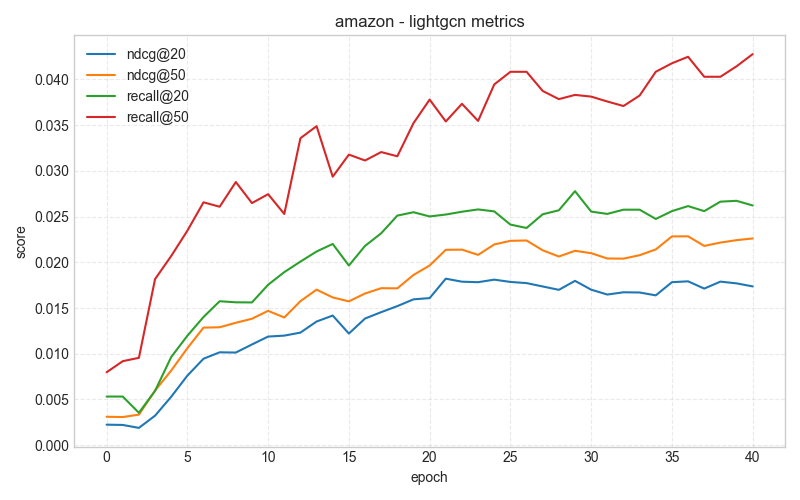

**amazon_lightgcn_epoch_time.png**

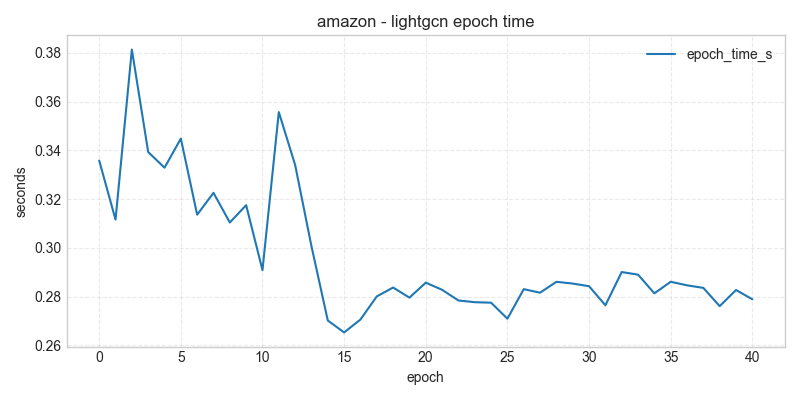

**amazon_lightgcn_loss.png**

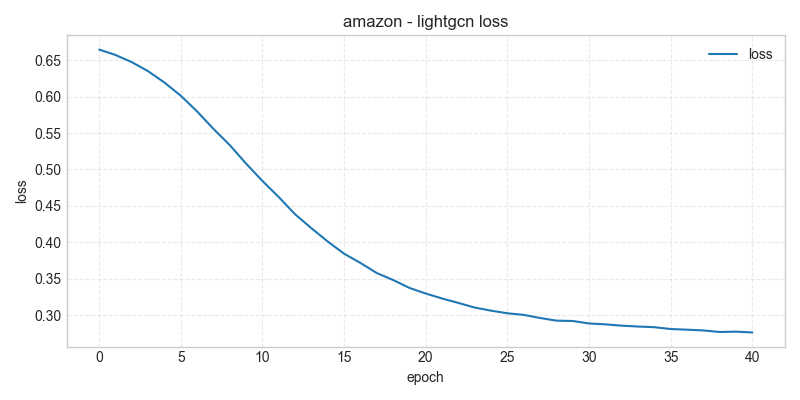

### ngcf (plots)

**amazon_ngcf_metrics.png**

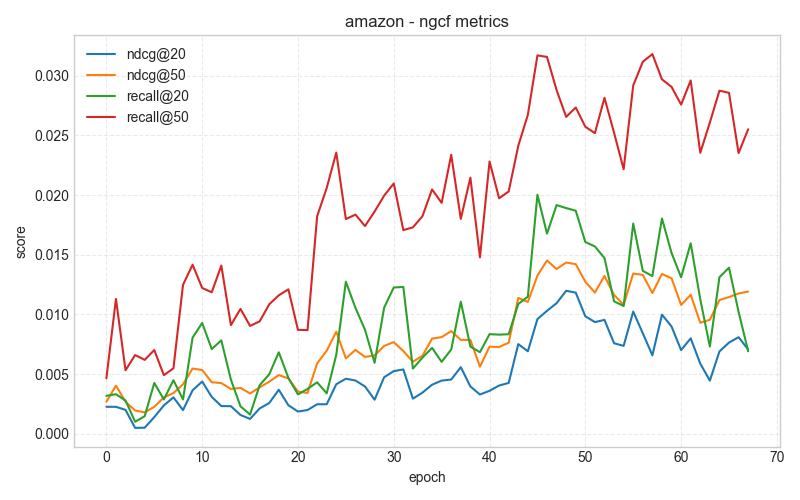

**amazon_ngcf_epoch_time.png**

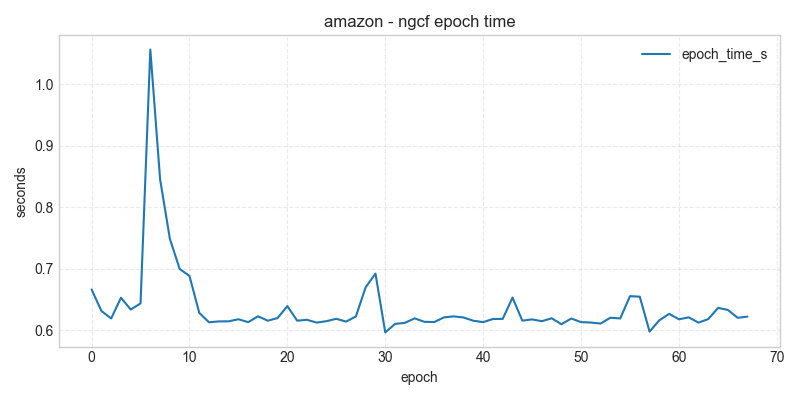

**amazon_ngcf_loss.png**

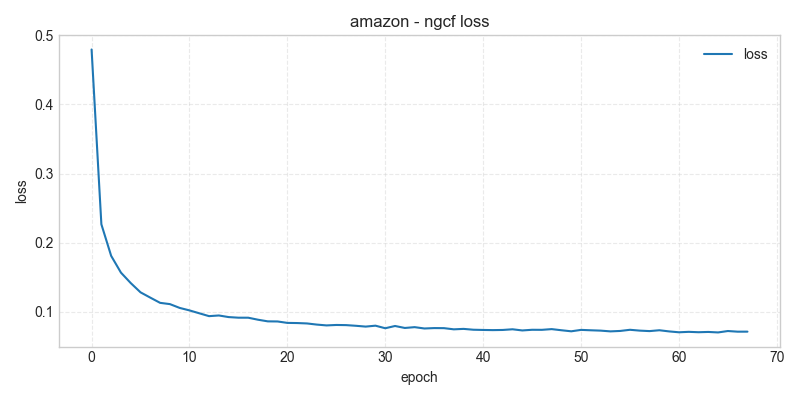

### mf-bpr (plots)

**amazon_mf-bpr_metrics.png**

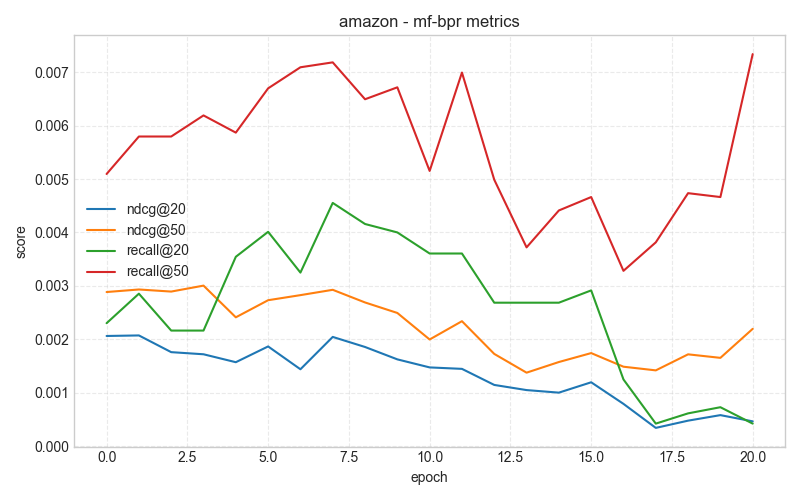

**amazon_mf-bpr_epoch_time.png**

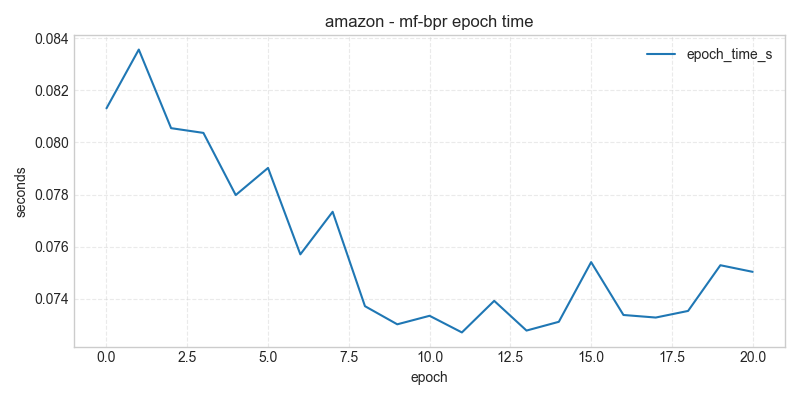

**amazon_mf-bpr_loss.png**

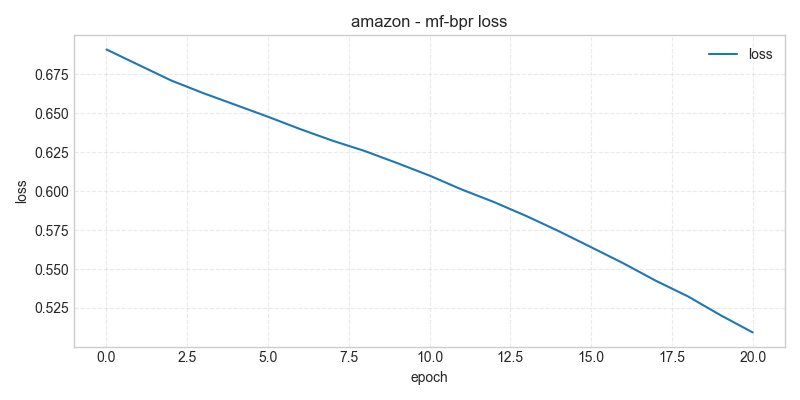

### wmf (plots)

**amazon_wmf_metrics.png**

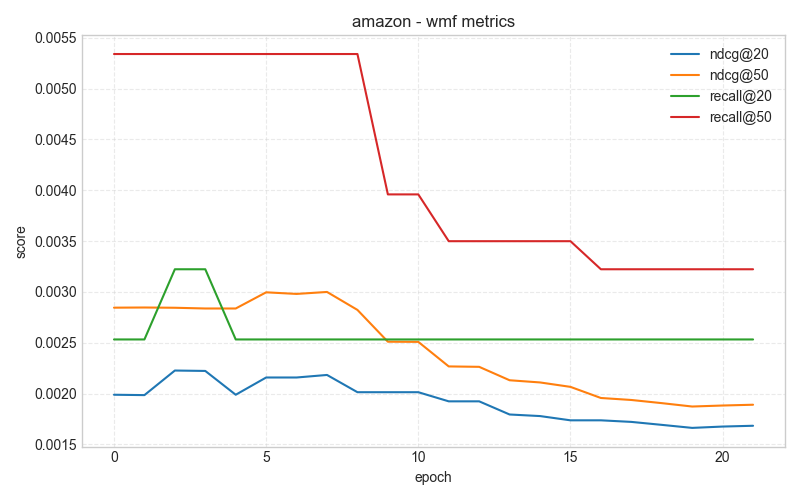

**amazon_wmf_epoch_time.png**

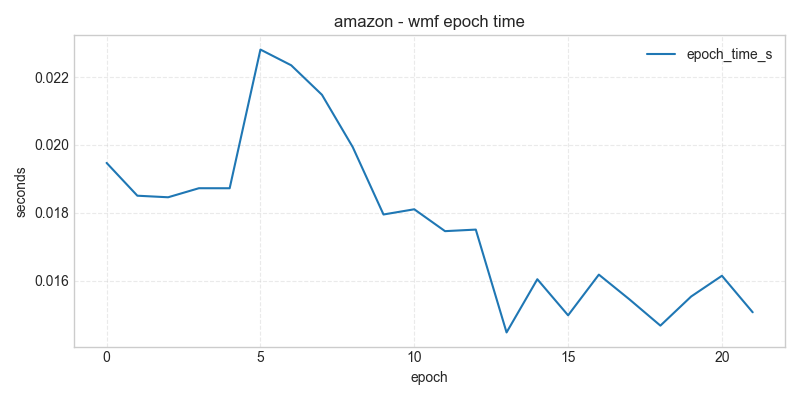

**amazon_wmf_loss.png**

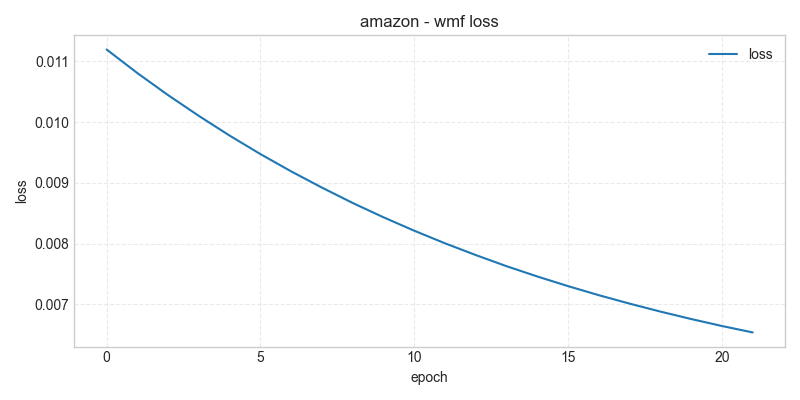

### mult-vae (plots)

**amazon_mult-vae_metrics.png**

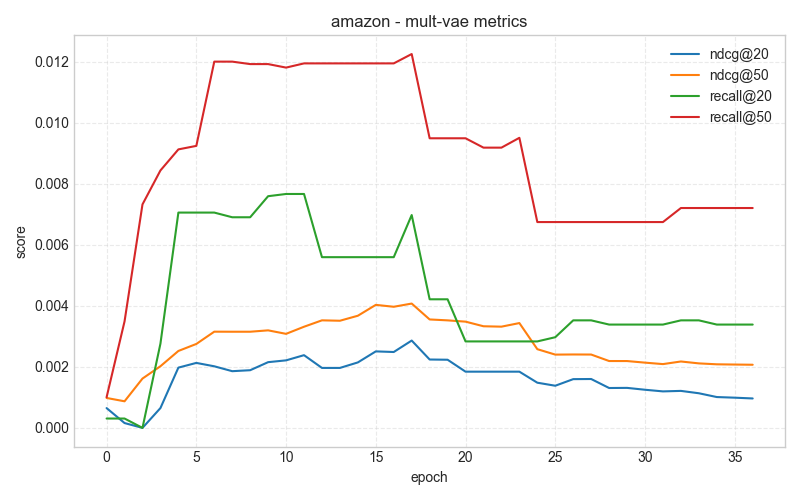

**amazon_mult-vae_epoch_time.png**

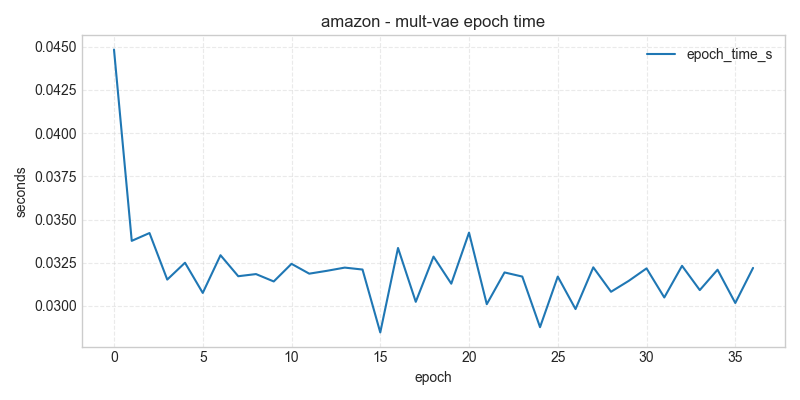

**amazon_mult-vae_loss.png**

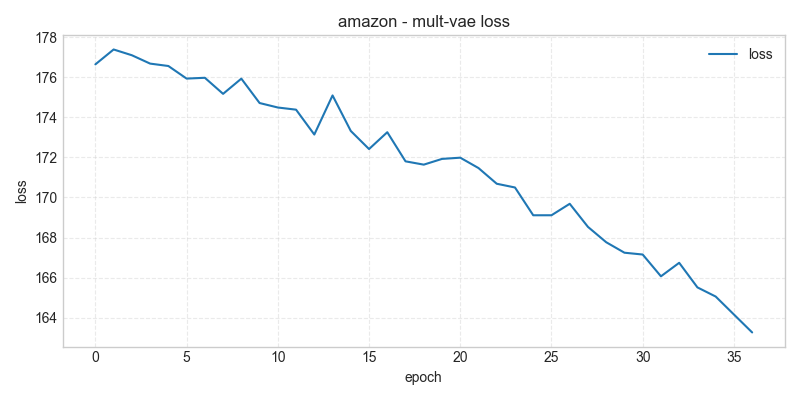

In [45]:
if runs:
    for r in runs:
        model = r['model']
        display(Markdown(f"### {model} (plots)"))
        show_saved_plots(model)
else:
    print('Run training first to see plots and learning curves.')


## Final report snippet
When you have real numbers, the block below formats a short narrative. Edit wording as needed for the paper.

In [48]:
if runs:
    # Pick the best by NDCG@20
    summary_df = pd.DataFrame([{**{'model': r['model']}, **r['metrics'][r['model']]} for r in runs])
    best = summary_df.sort_values('ndcg@20', ascending=False).iloc[0]
    report = (
        f"Top model: **{best['model']}** with NDCG@20={best.get('ndcg@20', float('nan')):.4f}, "
        f"Recall@20={best.get('recall@20', float('nan')):.4f}. "
        f"Training time (avg over seeds): {best.get('train_time_s', float('nan')):.1f}s."
    )
    display(Markdown(report))
else:
    print('Run training to auto-generate a summary paragraph.')


Top model: **lightgcn** with NDCG@20=0.0182, Recall@20=0.0252. Training time (avg over seeds): 14.7s.